# Preparing the environment

In [ ]:
!unzip /content/archive.zip

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.6.tgz
!tar -xvf spark-2.4.3-bin-hadoop2.6.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.6"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
!pip install findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
!pip install pyspark==2.4.4

In [ ]:
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, explode, initcap, regexp_replace, split, concat, substring, to_date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType

In [ ]:
spark = SparkSession \
        .builder \
        .appName("PySparkGooglePlayApps") \
        .getOrCreate()

# Dataset

The dataset that I used to work with has been taken from Kaggle:<br>
https://www.kaggle.com/lava18/google-play-store-apps

In this dataset we have 2 files: `googleplaystore.csv` (Apps) and `googleplaystore_user_reviews.csv` (Reviews).<br>
I will call them **Apps** and **User reviews** respectively.<br>

## Data Wrangling - Apps

Since some of the app names have a double quotation mark, we should indicate to `spark.read.load` that this character has to be escaped. Otherwise, we would have extra columns in the Dataframe.

In [ ]:
apps = spark.read.load("/content/googleplaystore.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    escape='"',
                    inferSchema='true')

Check that those App names have been correctly loaded:

In [ ]:
apps.select("App").where("App like '%\"%'").show(truncate=False)

In [ ]:
# Number of rows in the dataframe
apps.count()

### Transformations & Datatype conversions
To understand what we are going to do, let's first take a look at the data and the schema of the Dataframe:

In [ ]:
apps.show(1)

In [ ]:
apps.printSchema()

For this analysis we don't need all the columns but only a few of them, so let's start by dropping unwanted columns:

In [ ]:
# Drop unused columns
apps = apps.drop("category", "size", "type", "content rating")

Now we are going to focus on the following points:
1. **Column renaming**: Removing spaces.
1. **Rating**: Cast  to Double.
1. **Installs**: Apply regexp to remove unwanted characters and cast to Integer.
1. **Price**: Apply regexp to remove unwanted characters and cast to Double.
1. **Last updated**: Cast to Date.

In [ ]:
apps = apps \
    .withColumnRenamed("Android Ver", "android_ver") \
    .withColumnRenamed("Current Ver", "current_ver") \
    .withColumnRenamed("Last Updated", "last_updated") \
    .withColumn("Rating", col("Rating").cast(DoubleType())) \
    .withColumn("Reviews", col("Reviews").cast(IntegerType())) \
    .withColumn("Installs", regexp_replace(col("Installs"), "[^0-9]", "")) \
    .withColumn("Installs", col("Installs").cast(IntegerType())) \
    .withColumn("Price", regexp_replace(col("Price"), "[$]", "")) \
    .withColumn("Price", col("Price").cast(DoubleType())) \
    .withColumn("last_updated", to_date('last_updated', 'MMM d, yyyy'))

In [ ]:
# Fill NULL values with 0
apps = apps.fillna(0, "price")

With the new datatypes and cleaning actions, now the schema and data makes more sense.

In [ ]:
apps.printSchema()

In [ ]:
apps.show(5)

### Removing duplicates

According to the information that Kaggle shows about the dataset, there are 9660 unique values. Let's see then how to remove them.<br>
I applied my personal criteria for selecting the columns for which I will decide what is **unique**, but this could be different according to different business needs.

In [ ]:
#Create temporal view so later we can execute SQL statements
apps.createOrReplaceTempView("apps")

In [ ]:
# First glance of repeated apps
spark.sql("""
SELECT app, rating, reviews, installs, genres, price, android_ver, count(*) rep
FROM apps
GROUP BY app, rating, reviews, installs, genres, price, android_ver
HAVING count(*) > 1
ORDER BY rep DESC
""").show()

In the following example we can see one specific app with almost identical rows, the only difference is in the number of reviews and version (both *current_ver* and *last_updated*).

In [ ]:
# One specific example
spark.sql("""
SELECT  app, rating, reviews, installs, price,
        genres, last_updated, current_ver, android_ver,
        ROW_NUMBER() OVER (PARTITION BY app ORDER BY current_ver DESC, last_updated DESC, reviews DESC) row_number
FROM apps
WHERE app = "Farm Heroes Saga"
""").show(truncate=False)

Finally, to **remove duplicates** we are going to use the SQL analytical function `ROW_NUMBER()` establishing one specific order, and keeping only the first row of each app.

In [ ]:
# Remove duplicates
apps = spark.sql("""
WITH app_vw AS
    (SELECT app, rating, reviews, installs, price, genres, last_updated, current_ver, android_ver,
            ROW_NUMBER() OVER (PARTITION BY app ORDER BY current_ver DESC, last_updated DESC, reviews DESC) row_number
    FROM apps)
SELECT app, rating, reviews, installs, price, genres, last_updated, current_ver, android_ver
FROM app_vw
WHERE row_number = 1
""")

In [ ]:
apps.count()

The following Dataframe method will only remove completely identical rows by looking at **all the columns**.<br>
Since we have already removed the duplicates, it will have no effect on the Dataframe.

In [ ]:
apps = apps.dropDuplicates()

In [ ]:
apps.count()

In [ ]:
# Re-check of duplicates
apps.createOrReplaceTempView("apps")  # Update view

spark.sql("""
SELECT app, rating, reviews, installs, genres, price, android_ver, count(*) rep
FROM apps
GROUP BY app, rating, reviews, installs, genres, price, android_ver
HAVING count(*) > 1
""").show()

## User Reviews

For this second file of the dataset we are not going to apply any cleaning or datatype conversion.

In [ ]:
reviews = spark.read.load("/content/googleplaystore_user_reviews.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    escape='"',
                    inferSchema='true').cache()

In [ ]:
reviews.count()

In [ ]:
reviews.describe().show()

In [ ]:
reviews.createOrReplaceTempView("reviews")

# Business questions

### 1. Applications with at least 10.000 reviews, at least 50.000 installations and are supported on Android 4.0 and higher.

The tricky thing here is to find about Android number, since the column is a string and it has different values, some of them with text:

In [ ]:
spark.sql("""
SELECT DISTINCT android_ver
FROM apps
ORDER BY android_ver
""").show(40)

We can use `regexp_replace` function to get the first 2 digits, since we need to filter by the major version number `4` and the minor version number `0`.

In [ ]:
# Isolated check of version filtering
spark.sql("""
SELECT DISTINCT REGEXP_REPLACE(android_ver,"","") vers
FROM apps
WHERE CAST(SUBSTRING(REGEXP_REPLACE(android_ver,"[^0-9]",""), 0, 1) as INT) >= 4
ORDER BY 1
""").show()

Now the question can be easily answered.<br>
There is a total of 2133 apps that met those requirements.

In [ ]:
spark.sql("""
SELECT  app, 
        reviews, 
        installs, 
        android_ver, 
        COUNT(*) OVER () total
FROM apps
WHERE reviews >= 10000
AND installs >= 50000
AND CAST(SUBSTRING(REGEXP_REPLACE(android_ver,"[^0-9]",""), 0, 1) as INT) >= 4
""").show()

### 2. Top 10 applications in regards to the highest number of positive sentiments.

In [ ]:
spark.sql("""
SELECT app, count(*) cnt_pos
FROM reviews
WHERE sentiment = "Positive"
GROUP BY app
ORDER BY 2 DESC
LIMIT 10
""").show(truncate=False)

### 3. Histogram for the number of installations.

We use the SQL function `NVL` to replace NULL values with 0.

In [ ]:
histogram = spark.sql("""
SELECT  NVL(installs, 0) installs
        , count(*) frequency
FROM apps
GROUP BY NVL(installs, 0)
ORDER BY 1
""")

In [ ]:
# Programmatic way to replace NULL with 0
histogram = histogram.fillna(0, "installs")

In [ ]:
histogram.where("installs is null").show()

In [ ]:
histogram.show()

Now that we have the data we want to show, we need to convert to Pandas Dataframe so later we can use a the Pandas internal plot library.

In [ ]:
# Conversion: Spark DF to Pandas DF
plotdf = histogram.toPandas()

In [ ]:
# Pandas internal plot library
plotdf.plot(kind='barh', x='installs', y='frequency', colormap='tab20b')

### 4. How many distinct genres there are? How many apps for each genre?

In the dataset there is an **invalid row** where `Category` column is missing (this is different than having a NULL or empty value), so all the following columns for that row are affected. We can simply ignore this row in the following cells of this notebook.

In [ ]:
# Wrong case detected
spark.sql("""
SELECT *
FROM apps
where genres = "February 11, 2018"
""").show()

In this case we need to separate all the different groups of genres into a single one.<br>
To do that, we use a combination of `split` and `explode` functions.

A first step is to get all the genre values in list objects, since explode uses a list/array to later decompose them.

In [ ]:
spark.sql("""
SELECT DISTINCT SPLIT(genres, ";") genres
FROM apps
ORDER BY 1
""").show(30, truncate=False)

With the following query, we obtain all the different genres, a total of 54.

In [ ]:
genresDF = spark.sql("""
SELECT DISTINCT EXPLODE(SPLIT(genres, ";")) genres
FROM apps
ORDER BY 1
""")

In [ ]:
genresDF.count()

In [ ]:
genresDF.show()

For the second question related to genres, we need to use the previous query without `DISTINCT`, because we need every row (every app).<br>We can see that the top 3 genres for apps are *Tools*, *Education* and *Entertainment*.

In [ ]:
spark.sql("""
WITH app_vw AS
    (SELECT EXPLODE(SPLIT(genres, ";")) genres
    FROM apps)
SELECT genres, count(*) number_apps
FROM app_vw
GROUP BY genres
ORDER BY 2 DESC
""").show()

### 5. Applications with more positive sentiments than negative and neutral together and having a rating of at least 4.2.

Let's first see how is the sentiment distribution among the reviews.

In [ ]:
spark.sql("""
SELECT DISTINCT sentiment
        , COUNT(*) OVER(PARTITION BY sentiment) sent_tot
        , COUNT(*) OVER() total
        , ROUND(COUNT(*) OVER(PARTITION BY sentiment) / COUNT(*) OVER() * 100, 2) percent
FROM reviews
""").show()

In the following query we count the different sentiments for each app:

In [ ]:
spark.sql("""
SELECT  app, 
        SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive, 
        SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative, 
        SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
FROM reviews r
WHERE r.sentiment != "nan"
GROUP BY app
""").show(truncate=False)

Using the previous query as a view, we can now get the final answer:

In [ ]:
spark.sql("""
WITH reviews_vw AS
    (SELECT app, 
            SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive, 
            SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative, 
            SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
    FROM reviews r
    WHERE r.sentiment != "nan"
    GROUP BY app
    )
SELECT a.app, a.rating, positive, negative, neutral
FROM apps a, reviews_vw r
WHERE a.app = r.app
AND a.rating >= 4.2
AND positive > neutral + negative
""").show(30, truncate=False)

### 6. Trying to find correlation between some of the attributes.

In the **first case**, I tried to find some correlation between sentiment and rating.<br>
What I found is that rating is mostly similar in both very positive and negative sentiments. I would have expected much worse rating for those with negative sentiment, but the data shows that it's only slightly lower.

**Positive sentiment**

In [ ]:
spark.sql("""
WITH apps_vw AS
    (SELECT app, rating, reviews, installs, price, genres
    FROM apps
    ),
reviews_vw AS
    (SELECT app, 
            SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive, 
            SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative, 
            SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
    FROM reviews r
    WHERE r.sentiment != "nan"
    GROUP BY app
    )
SELECT a.app, price, rating, installs, reviews, positive, negative, neutral
FROM apps_vw a, reviews_vw r
WHERE a.app = r.app
AND positive > negative + neutral
ORDER BY positive DESC
""").show()

**Negative sentiment**

In [ ]:
spark.sql("""
WITH apps_vw AS
    (SELECT app, rating, reviews, installs, price, genres
    FROM apps
    ),
reviews_vw AS
    (SELECT app,
            SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive, 
            SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative, 
            SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
    FROM reviews r
    WHERE r.sentiment != "nan"
    GROUP BY app
    )
SELECT a.app, price, rating, installs, reviews, negative, positive, neutral
FROM apps_vw a, reviews_vw r
WHERE a.app = r.app
AND negative > positive + neutral
ORDER BY negative DESC
""").show()

In the **second case**, I tried to find correlation between price and number of installations.<br>
The most expensive apps are not frequently installed.

In [ ]:
spark.sql("""
SELECT app, price, rating, installs, genres, reviews
FROM apps
ORDER BY price DESC, installs
""").show(30, truncate=False)

And showing the opposite side, the cheaper the app is, the more times it gets installed.

In [ ]:
spark.sql("""
SELECT    CASE WHEN price = 0 THEN 1 ELSE 0 END Free
        , CASE WHEN price > 0 AND price <= 10 THEN 1 ELSE 0 END `0.1to10`
        , CASE WHEN price > 10 AND price <= 20 THEN 1 ELSE 0 END `10to20`
        , CASE WHEN price > 20 AND price <= 50 THEN 1 ELSE 0 END `20to50`
        , CASE WHEN price > 50 AND price <= 100 THEN 1 ELSE 0 END `50to100`
        , CASE WHEN price > 100 AND price <= 200 THEN 1 ELSE 0 END `100to200`
        , CASE WHEN price > 200 AND price <= 300 THEN 1 ELSE 0 END `200to300`
        , CASE WHEN price > 300 AND price <= 400 THEN 1 ELSE 0 END `300to400`
        , SUM(installs) total_installs
FROM apps
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8
ORDER BY 9 DESC
""").show()

We can show what percentage represents each of the values and have a better idea of the distribution.<br>
In order to do that, we use the previous query as a view:

In [ ]:
spark.sql("""
WITH app_vw AS
        (select   CASE WHEN price = 0 THEN 1 ELSE 0 END Free
                , CASE WHEN price > 0 AND price <= 10 THEN 1 ELSE 0 END `0.1to10`
                , CASE WHEN price > 10 AND price <= 20 THEN 1 ELSE 0 END `10to20`
                , CASE WHEN price > 20 AND price <= 50 THEN 1 ELSE 0 END `20to50`
                , CASE WHEN price > 50 AND price <= 100 THEN 1 ELSE 0 END `50to100`
                , CASE WHEN price > 100 AND price <= 200 THEN 1 ELSE 0 END `100to200`
                , CASE WHEN price > 200 AND price <= 300 THEN 1 ELSE 0 END `200to300`
                , CASE WHEN price > 300 AND price <= 400 THEN 1 ELSE 0 END `300to400`
                , SUM(installs) total_installs
        from apps
        GROUP BY 1, 2, 3, 4, 5, 6, 7, 8)
SELECT *,
       ROUND(total_installs / SUM(total_installs) OVER () * 100, 2) percent
FROM app_vw
ORDER BY 9 DESC
""").show()

In the **third case**, I tried to find correlation between rating and number of installations.<br>
It's clear here that higher rated apps are more frequently installed. (*last row are apps with NULL rating*)

In [ ]:
spark.sql("""
SELECT CASE WHEN rating <= 2 THEN 1 ELSE 0 END `0-2`
        , CASE WHEN rating > 2 AND rating <= 3 THEN 1 ELSE 0 END `2-3`
        , CASE WHEN rating > 3 AND rating <= 4 THEN 1 ELSE 0 END `3-4`
        , CASE WHEN rating > 4 AND rating <= 5 THEN 1 ELSE 0 END `4-5`
        , SUM(installs)
FROM apps
GROUP BY 1, 2, 3, 4
ORDER BY 5 DESC
""").show()

<a id = '1.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color :#4682B4; border-radius: 5px 5px;"><strong>Google Play Store Apps</strong></p>


* Today, 1.85 million different apps are available for users to download. Android users have even more from which to choose, with 2.56 million available through the Google Play Store. These apps have come to play a huge role in the way we live our lives today.

<a id = '0.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Table of Contents</strong></p> 

* [Importing libraries](#1.0)
* [Importing dataset](#2.0)
* [Basic Data Exploration(Understanding the Dataset](#3.0)
* [Data Cleaning](#0.0)
    * [Checking for null values](#5.0)
    * [delete data duplicated](#6.0)
    * [Check Qutliers](#7.0)
* [Exploratory Data Analysis (EDA)](#8.0)
* [Check Co-relation](#9.0)

<a id = '1.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Importing libraries</strong></p>

In [ ]:
!unzip /content/archive.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from wordcloud import WordCloud
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

<a id = '2.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Importing dataset </strong></p>

In [ ]:
data=pd.read_csv('/content/googleplaystore.csv')

<a id = '3.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Basic Data Exploration(Understanding the Dataset</strong></p>

#### We will check the below things:

* head of the dataset
* the shape of the dataset
* datatypes for every column 
* summary of the dataset


In [ ]:
data.head()

In [ ]:
# Take a sample of 5
data.sample(5)

In [ ]:
data.shape

In [ ]:
data.columns

In [ ]:
#The described method will help to see how data has been spread for numerical values.
# We can clearly see the minimum value, mean values, different percentile values, and maximum values.
data.describe(include='all').T

In [ ]:
#info() is used to check the Information about the data and the datatypes of each respective attribute.
data.info() 

* The data has 12 object and 1 numeric feature

#### we need to convert [`Reviews` & `Size`  &  `Installs` & `Price`] to int
* [Reviews](#11.0)
* [Size](#12.0)
* [Installs](#13.0) &  [Price](#14.0)

#### we need to Change Last update into a datetime column



* [Reviews](#1.0)


# Checking if all values in number of Reviews numeric
data.Reviews.str.isnumeric().sum()


* One value is non numeric out of 10841. Lets find its value and id.


In [ ]:
data[~data.Reviews.str.isnumeric()]

* We could have converted it into interger like we did for Size but the data for this App looks different. It can be noticed that the entries are entered wrong  We could fix it by setting Category as nan and shifting all the values, but deleting the sample for now.

In [ ]:
data=data.drop(data.index[10472])

In [ ]:
data["Reviews"] = data["Reviews"].astype(int)

In [ ]:
data.info()  

* [Size](#12.0)

* It can be seen that data has metric prefixes (Kilo and Mega) along with another string. Replacing k and M with their values to convert values to numeric.

In [ ]:
data['Size'].unique()

* Remove all characters from size and convert it to float

In [ ]:
data['Size']=data['Size'].str.replace('M','000')
data['Size']=data['Size'].str.replace('k','')
#apps['size']=apps['size'].str.replace('.','')
data['Size']=data['Size'].replace("Varies with device",np.nan)
data['Size']=data['Size'].astype('float')
data['Size']

* There is a problem!! There are some applications size in megabyte and some in kilobyte


In [ ]:
###### Convert mega to kilo then convert all to mega
for i in data['Size']:
    if i < 10:
        data['Size']=data['Size'].replace(i,i*1000)
data['Size']=data['Size']/1000
data['Size']

In [ ]:
data.info()

* [Installs](#13.0) &  [Price](#13.0)


In [ ]:
data['Installs'].unique()

In [ ]:
data['Price'].unique()

In [ ]:
items_to_remove=['+',',','$']
cols_to_clean=['Installs','Price']
for item in items_to_remove:
    for col in cols_to_clean:
        data[col]=data[col].str.replace(item,'')
data.head()

In [ ]:
data.Installs.unique()

In [ ]:
data['Price'].unique()

In [ ]:
data[data['Price']=='Everyone']

In [ ]:
data['Installs']=data['Installs'].astype('int')
data['Price']=data['Price'].astype('float')
data.info()

* [last updated](#12.0)

In [ ]:
#### Change Last update into a datetime column
data['Last Updated'] = pd.to_datetime(data['Last Updated'])
data['Last Updated']

In [ ]:
data['Updated_Day']=data['Last Updated'].dt.day
data['Updated_Month']=data['Last Updated'].dt.month
data['Updated_Year']=data['Last Updated'].dt.year

In [ ]:
data.drop('Last Updated', axis=1, inplace=True)

In [ ]:
data.head()

In [ ]:
data.info()

<a id = '0.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #006400; border-radius: 5px 5px;"><strong>Data Cleaning</strong></p>


#### Garbage in Garbage out
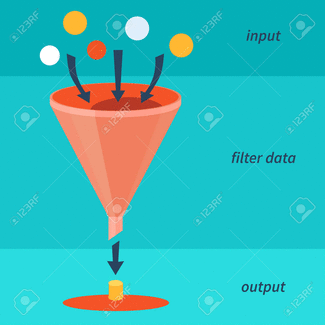

<a id = '5.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Checking for null values</strong></p>


In [ ]:
null = pd.DataFrame({'Null Values' : data.isna().sum().sort_values(ascending=False), 'Percentage Null Values' : (data.isna().sum().sort_values(ascending=False)) / (data.shape[0]) * (100)})
null

In [ ]:
null_counts = data.isna().sum().sort_values(ascending=False)/len(data)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

* I Clean missing values using Random Value Imputation Because This the best way to To maintain distrbuation For each feature.

In [ ]:
### lets create a function so that I can easily do it for all features
def Random_value_imputation(feature):
    random_sample=data[feature].dropna().sample(data[feature].isnull().sum())               
    random_sample.index=data[data[feature].isnull()].index
    data.loc[data[feature].isnull(),feature]=random_sample

In [ ]:
for col in data:
    Random_value_imputation(col)

In [ ]:
null = pd.DataFrame({'Null Values' : data.isna().sum().sort_values(ascending=False), 'Percentage Null Values' : (data.isna().sum().sort_values(ascending=False)) / (data.shape[0]) * (100)})
null

In [ ]:
null_counts = data.isna().sum().sort_values(ascending=False)/len(data)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

<a id = '6.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>delete data duplicated</strong></p>

In [ ]:
duplicate = data.duplicated()
print(duplicate.sum())

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
duplicate = data.duplicated()
print(duplicate.sum())

<a id = '5.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong> Extract Numerical & Categorical Features</strong></p> 

In [ ]:
num_features=[col for col in data.columns if data[col].dtype!='O']
num_features

In [ ]:
num_data = data[num_features]
num_data.head()

In [ ]:
cat_features=[col for col in data.columns if data[col].dtype=='O']
cat_features

In [ ]:
categorical=data[cat_features]
categorical.head()

<a id = '7.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Check Qutliers</strong></p>

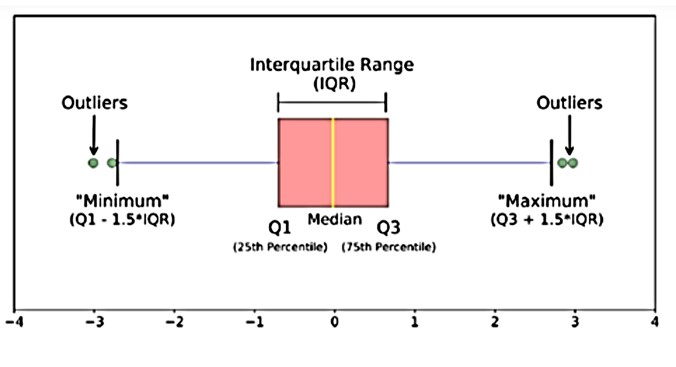

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.10)
    quartile3 = dataframe[variable].quantile(0.90)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
def has_outliers(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].any(axis=None):
        print(variable, "yes")
    print(variable, "no")

In [ ]:
for col in num_data.columns:
    has_outliers(num_data, col)

In [ ]:
plt.figure(figsize=(22,18))
for i,col in enumerate(num_data.columns):
    plt.subplot(4,9,i+1)
    sns.boxplot(num_data[col])

In [ ]:
## function to get ride of qutliers
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
replace_with_thresholds(num_data, num_data.columns)

In [ ]:
for col in num_data.columns:
    has_outliers(num_data, col)

In [ ]:
plt.figure(figsize=(22,18))
for i,col in enumerate(num_data.columns):
    plt.subplot(4,9,i+1)
    sns.boxplot(num_data[col])

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Exploratory Data Analysis (EDA)</strong></p>

###  What is EDA ?
is an approach for data analysis that emeploys a variety of technics (mostly graphical) to  
*  maximize insight into a dataset
*   uncover underlying structure     
*   extract important variables      
*   answer questions 

### EDA Checklist
1. What question(s) are you trying to solve ? 
2. What kind of data do you have and how do you treat different types? 
3. What do you get after visualize your data?
4. What is your observation 

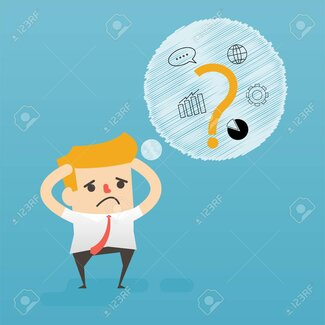

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Category Column</strong></p>

In [ ]:
categorical['Category'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(x='Category',data=data)
plt.xticks(rotation=70)

In [ ]:
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(
                          background_color='black',
                          width=1920,
                          height=1080
                         ).generate(" ".join(data.Category))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
Category1 = data[data.Category=="GAME"].Rating
Category2 = data[data.Category=="FAMILY"].Rating
Category3 = data[data.Category=="MEDICAL"].Rating

fig = go.Figure()
fig.add_trace(go.Box(x=Category1, name='GAME'))
fig.add_trace(go.Box(x=Category2, name='FAMILY'))
fig.add_trace(go.Box(x=Category3, name='MEDICAL'))

fig.show()

### Category vs Rating Analysis

In [ ]:
plt.figure(figsize=(20,15))
sns.boxplot(y='Rating',x='Category',data = data.sort_values('Rating',ascending=False))
plt.xticks(rotation=80)

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Type Column</strong></p>

In [ ]:
categorical['Type'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = (8,5)
sns.countplot(x='Type',data=data)
plt.xticks(rotation=70)

In [ ]:
data["Type"].value_counts().plot.pie(autopct = "%1.1f%%")

### Type vs Rating Analysis

In [ ]:
plt.figure(figsize=(15,8))
sns.catplot(y='Rating',x='Type',data = data.sort_values('Rating',ascending=False),kind='boxen')

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Content Rating Column</strong></p>

In [ ]:
categorical['Content Rating'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(x='Content Rating',data=data)
plt.xticks(rotation=70)

In [ ]:
# pie chart
values = data['Content Rating'].value_counts()
labels = ['Everyone', 'Teen', 'Mature 17+','Everyone 10+','Adults only 18+','Unrated']

fig, ax = plt.subplots(figsize = (12, 8), dpi = 100)
explode = (0,0,0,0,0,.02)

patches, texts, autotexts = ax.pie(values, labels = labels, autopct = '%1.2f%%', shadow = True,
                                   startangle = 0, explode = explode)

plt.setp(texts, color = 'grey')
plt.setp(autotexts, size = 15, color = 'white')
autotexts[1].set_color('black')
plt.show()

### Content Rating vs Rating Analysis

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(y='Rating',x='Content Rating',data = data.sort_values('Rating',ascending=False))
plt.xticks(rotation=90)

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x="Content Rating", y="Installs", hue="Type", data=data)

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Genres Column</strong></p>

In [ ]:
categorical['Genres'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(x='Genres',data=data)
plt.xticks(rotation=90)

### Content Rating vs Genres Analysis

In [ ]:
plt.figure(figsize=(20,15))
sns.boxplot(y='Rating',x='Genres',data = data.sort_values('Rating',ascending=False))
plt.xticks(rotation=90)

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Current Ver Column</strong></p>

In [ ]:
categorical['Current Ver'].value_counts()

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Android Ver Column</strong></p>

In [ ]:
categorical['Android Ver'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(x='Android Ver',data=data)
plt.xticks(rotation=30)

### Content Rating vs Android Ver Analysis

In [ ]:
plt.figure(figsize=(20,15))
sns.boxplot(y='Rating',x='Android Ver',data = data.sort_values('Rating',ascending=False))
plt.xticks(rotation=90)

### Defining violin and scatter plot & kde_plot functions

In [ ]:
def violin(col):
    fig = px.violin(data, y=col, x="Type", color="Type", box=True , template = 'plotly_dark')
    return fig.show()

def scatters(col1,col2):
    fig = px.scatter(data, x=col1, y=col2, color="Type" ,template = 'plotly_dark')
    return fig.show()

def kde_plot(feature):
    grid = sns.FacetGrid(data, hue="Type",aspect=2)
    grid.map(sns.kdeplot, feature)
    grid.add_legend()

* kde_plot Analysis

In [ ]:
kde_plot('Rating')

In [ ]:
kde_plot('Updated_Day')

In [ ]:
kde_plot('Size')

In [ ]:
kde_plot('Updated_Month')

In [ ]:
kde_plot('Price')

In [ ]:
kde_plot('Updated_Year')

* scatter plot Analysis

In [ ]:
scatters('Price', 'Updated_Year')

In [ ]:
scatters('Size', 'Rating')

In [ ]:
scatters('Size', 'Installs')

In [ ]:
scatters('Updated_Month', 'Installs')

In [ ]:
scatters('Reviews', 'Rating')

In [ ]:
scatters('Rating', 'Price')

 * violin plot Analysis

In [ ]:
violin('Rating')

In [ ]:
violin('Reviews')

In [ ]:
violin('Size')

In [ ]:
violin('Installs')

In [ ]:
violin('Price')

In [ ]:
violin('Updated_Month')

In [ ]:
violin('Updated_Year')

In [ ]:
freq= pd.Series()
freq=data['Updated_Year'].value_counts()
freq.plot()
plt.xlabel("Dates")
plt.ylabel("Number of updates")
plt.title("Time series plot of Last Updates")

<a id = '9.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Check Co-relation</strong></p>


In [ ]:
corelation = pd.DataFrame({'corelation' : data.corr()["Rating"].abs().sort_values(ascending=False)[1:]})
corelation

In [ ]:
plt.figure(figsize=(10,8))
corelation = data.corr()
sns.heatmap(corelation,annot=True ,linewidths=0.5,linecolor="black", fmt= '.1f')

<a id = '6.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Separate dependent & independent features</strong></p>

In [ ]:
y=data['Rating']
X=num_data
cols=X.columns
cols

<a id = '7.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Splitting Dataset</strong></p>


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=0.75,random_state=0)

In [ ]:
# Import Libraries
from sklearn.preprocessing import StandardScaler

In [ ]:
#Creating a StandardScaler object to normalize the X train and test set feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)


<a id = '13.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Defining function For ML model</strong></p>

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
!pip install xgboost
!pip install catboost

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

In [ ]:
estimators = [
     ('rf', RandomForestRegressor()),
    ('mlp', MLPRegressor(random_state=1, max_iter=500))
 ]

In [ ]:
def predict(ml_model):          
    model=ml_model.fit(X_train,y_train)
    print('Training score : {}'.format(model.score(X_train,y_train)))
    print('\n')
    y_prediction=model.predict(X_test)
    print('Testing score : {}'.format(model.score(X_test,y_prediction)))
    print('\n')

    print('predictions are: \n {}'.format(y_prediction[:10]))
    print('\n')
    r2_score=metrics.r2_score(y_test,y_prediction)
    print('r2 score: {}'.format(r2_score))
    print('MAE:',metrics.mean_absolute_error(y_test,y_prediction))
    print('MSE:',metrics.mean_squared_error(y_test,y_prediction))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_prediction)))


<a id = '12.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Gradient Boosting</strong></p> 


In [ ]:
predict(GradientBoostingRegressor())

In [ ]:
predict(RandomForestRegressor())

In [ ]:
predict(BaggingRegressor())

In [ ]:
predict(LinearRegression())

In [ ]:
predict(RANSACRegressor(base_estimator=LinearRegression(), max_trials=100))

In [ ]:
predict(Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42))

In [ ]:
predict(Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42))

In [ ]:
predict(ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42))

In [ ]:
predict(SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000))

In [ ]:
predict(xgb.XGBRegressor())

In [ ]:
predict(lgb.LGBMRegressor())

In [ ]:
predict(MLPRegressor(random_state=1, max_iter=500))

In [ ]:
predict(SVR(kernel='rbf', C=1000000, epsilon=0.001))

In [ ]:
predict(SVR(kernel='rbf', C=1000000, epsilon=0.001))

In [ ]:
estimators = [
   ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('svr', make_pipeline(StandardScaler(),
                           LinearSVC(random_state=42))) ]
 predict(StackingClassifier(estimators=estimators, final_estimator=LogisticRegression() ))